In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
from astropy import units
from astropy import constants as const


import seaborn as sns

sns.set(context="poster", font_scale=1.5)

import os
import glob

import dimensionalize_sedov

hbar     = const.hbar.cgs.value
k_b      = 1.380649e-16
m_proton = 1.672622e-24



pc       = units.pc.to(units.cm)
yr       = units.yr.to(units.s)
M_solar  = units.MsolMass.to(units.g)
gamma    = 5./3
mu       = .67       # mean molecular weight [dimensionless]


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [12]:
(.7/2) + (.2 / (3/4)) + (.20 / (.5))

1.0166666666666666

checkpoint:  checkpoint_0099.dat
time:  94114.3496337 [yr]
zones:  1315
energy conserved to:  -3.79472350907e-08


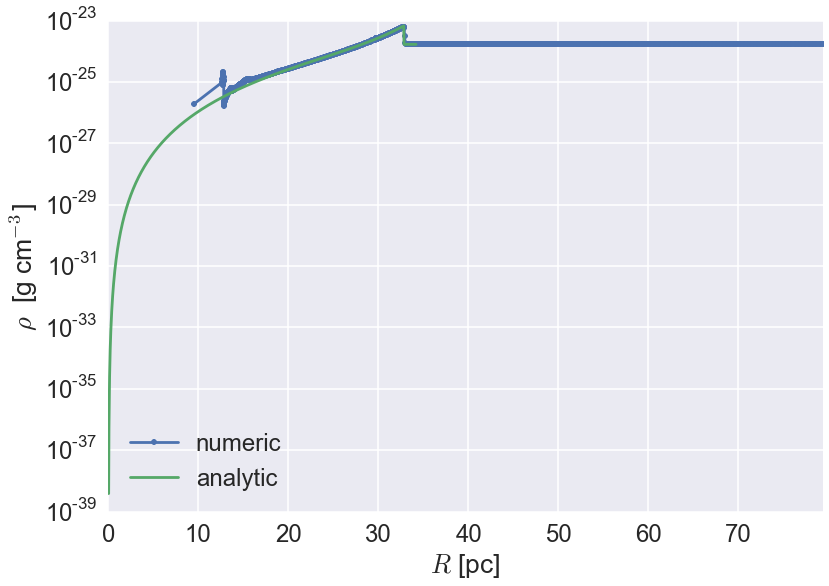

In [5]:
data_dir = ''
# data_dir = 'saved_runs/riemann/hydro/'
# data_dir = 'saved_runs/riemann/hydro_with_cooling/'


checkpoint_filenames = glob.glob(data_dir + "checkpoint_*.dat")
if os.path.exists(data_dir + "output.dat"):
    checkpoint_filenames.append(data_dir + "output.dat")
num_checkpoints = len(checkpoint_filenames)
    
times = np.empty(num_checkpoints)
for k, checkpoint_filename in enumerate(checkpoint_filenames):
    f = open(checkpoint_filename, 'r')
    line = f.readline()
    times[k] = float(line.split()[3])
    f.close()

def calc_mass(density, dV):
    mass = density * dV
    return mass

def calc_kinetic_energy(mass, velocity):
    E_kin = (1./2) * mass * velocity**2.
    return E_kin.sum()

def calc_internal_energy(mass, pressure, density):
    E_int = mass * (1./(gamma-1)) * pressure / density
    return E_int.sum()

E_int = np.empty(num_checkpoints)
E_kin = np.empty(num_checkpoints)
E_tot = np.empty(num_checkpoints)
M_tot = np.empty(num_checkpoints)
zones = np.empty(num_checkpoints)

#### PARSE DATAFILES INTO DATAFRAME
cols = ["Radius", "dR", "dV", "Density", "Pressure", "Velocity", "X", "Alpha", "Temperature", "Energy", "Entropy", "Mass", "M_int"]
cols_in = cols[:-5]
cols_plot = cols[0:6] + cols[8:]

df = pd.DataFrame()
for k, checkpoint_filename in enumerate(checkpoint_filenames):
    array_tmp = np.loadtxt(checkpoint_filename)
    index = pd.MultiIndex.from_product([k, range(array_tmp.shape[0])], names=["k","i"])
    df_tmp = pd.DataFrame(array_tmp, columns=cols_in, index = index)
    
    df_tmp["Temperature"] = (df_tmp.Pressure / df_tmp.Density) * (mu * m_proton / k_b)
    df_tmp["Energy"] = (df_tmp.Pressure / df_tmp.Density) / (gamma-1)
    df_tmp["Entropy"] = 2.5 - \
        np.log( (df_tmp.Density/(mu * m_proton)) * (2*np.pi*hbar**2 / (mu * m_proton * k_b * df_tmp.Temperature))**1.5 )
    df_tmp["Mass"]  = calc_mass(df_tmp.Density, df_tmp.dV)
    df_tmp["M_int"] = df_tmp.Mass.cumsum()
    E_kin[k] = calc_kinetic_energy(df_tmp.Mass, df_tmp.Velocity)
    E_int[k] = calc_internal_energy(df_tmp.Mass, df_tmp.Pressure, df_tmp.Density)
    E_tot[k] = E_kin[k] + E_int[k]
    M_tot[k] = df_tmp.M_int[-1]
    zones[k] = df_tmp.shape[0]
    
    df = pd.concat([df, df_tmp])
df.Radius /= pc
df.Mass /= M_solar
df.M_int /= M_solar


#### PLOT ####
label_dict = {"Radius"      :"$R$ [pc]", 
              "Velocity"    : r"$U$ [cm s$^{-1}$]",
              "Density"     : r"$\rho$  [g cm$^{-3}$]",
              "Temperature" : r"$T$ [K]",
              "Mass"        : r"$M$ [$M_\odot$]",
              "M_int"       : r"$M_\mathrm{int}$ [$M_\odot$]",
              "C_ad"        : r"$C_{ad}$ [cm s$^{-1}$]",
              "Energy"      : r"$E_{int}$ [erg g$^{-1}$]",
              "Pressure"    : r"$P$ [dyne cm$^{-2}$]",
              "Entropy"     : r"$S$ [$k_B$ / particle]",
              "M_int"       : r"$M_{int}$ [$M_\odot$]",
              "dR"          : r"$\Delta R$ [cm]",
              "dV"          : r"$\Delta V$ [cm$^3$]",
              "X"           : r"$X$ (passive scalar)",
              "Alpha"       : r"$\alpha$ (turbulence strength)"
             }


def plotter(y_axis_variable = "Density",
            Radius_as_x_axis = True,
            outer_limit_log = 0.5, 
            checkpoint_index = 0):
    marker="."
    
    df_tmp = df.loc[checkpoint_index]
    
    checkpoint_filename = checkpoint_filenames[checkpoint_index]
    time = times[checkpoint_index]

    print("checkpoint: ", checkpoint_filename)
    print("time: ", time / yr, "[yr]")

    print("zones: ", df_tmp.shape[0])
    print("energy conserved to: ", (E_tot[checkpoint_index] - E_tot[0]) / E_tot[0])
    
    if Radius_as_x_axis:
        x_axis_variable = "Radius"
        plt.xlim((0,10**outer_limit_log))
    else:
        x_axis_variable = "M_int"
        
    plt.plot(df_tmp[x_axis_variable], df_tmp[y_axis_variable], marker=marker, label="numeric")  
    
    
    sedov_cols = ["Radius", "Velocity", "Density", "Temperature", "C_ad", "Energy", "Pressure", "Entropy", "Mass"]
    if y_axis_variable in sedov_cols:
        sedov = dimensionalize_sedov.main(time)
        sedov = np.array(sedov).transpose()
        df_sedov = pd.DataFrame.from_records(sedov, 
                                             columns=sedov_cols)
        df_sedov.Radius /= pc
        df_sedov.Mass /= M_solar
        df_sedov["M_int"] = df_sedov.Mass.cumsum()
        
        plt.plot(df_sedov[x_axis_variable], df_sedov[y_axis_variable], label="analytic")  
        
    plt.xlabel(label_dict[x_axis_variable])
    plt.ylabel(label_dict[y_axis_variable])
    plt.yscale("log")
    plt.legend(loc="best")




interact(plotter,
        outer_limit_log = (-1., 2.),
        checkpoint_index=(0, num_checkpoints-1),
        y_axis_variable = cols_plot,
        Radius_as_x_axis = True)

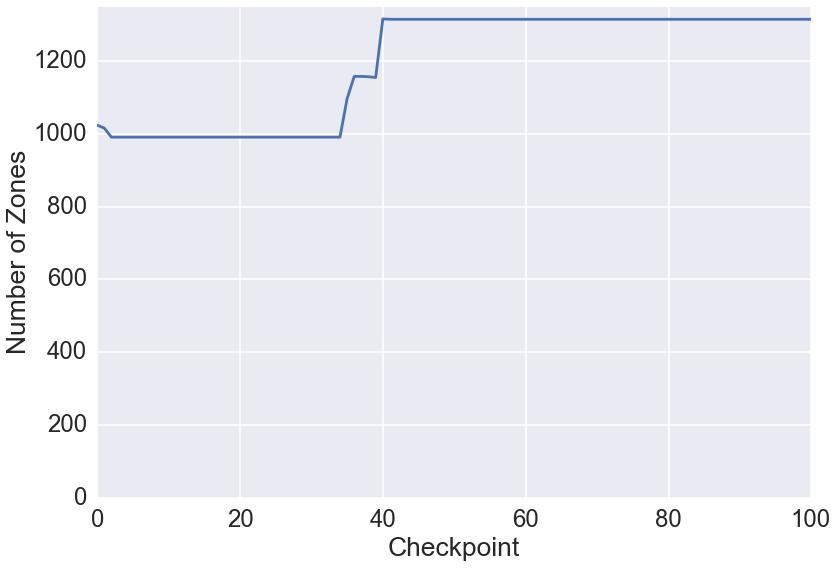

In [6]:
plt.plot(zones)
plt.ylim(ymin=0)
plt.ylabel("Number of Zones")
plt.xlabel("Checkpoint")

In [7]:
E_err = (E_tot - E_tot[0]) / E_tot[0]
print(E_tot)
# plt.plot(abs(E_err))
# plt.yscale("log")
plt.plot(E_tot)


[  1.37830364e+51   1.37830368e+51   1.37830354e+51   1.37830362e+51
   1.37830357e+51   1.37830357e+51   1.37830359e+51   1.37830358e+51
   1.37830358e+51   1.37830357e+51   1.37830358e+51   1.37830362e+51
   1.37830360e+51   1.37830359e+51   1.37830360e+51   1.37830359e+51
   1.37830359e+51   1.37830361e+51   1.37830361e+51   1.37830361e+51
   1.37830362e+51   1.37830359e+51   1.37830359e+51   1.37830360e+51
   1.37830360e+51   1.37830362e+51   1.37830360e+51   1.37830361e+51
   1.37830361e+51   1.37830360e+51   1.37830362e+51   1.37830358e+51
   1.37830359e+51   1.37830361e+51   1.37830361e+51   1.37830357e+51
   1.37830360e+51   1.37830360e+51   1.37830359e+51   1.37830359e+51
   1.37830359e+51   1.37830360e+51   1.37830359e+51   1.37830360e+51
   1.37830360e+51   1.37830358e+51   1.37830360e+51   1.37830356e+51
   1.37830356e+51   1.37830360e+51   1.37830358e+51   1.37830360e+51
   1.37830361e+51   1.37830362e+51   1.37830359e+51   1.37830360e+51
   1.37830359e+51   1.37830358e+51

AttributeError: 'float' object has no attribute 'rint'